In [1]:
# Test imports
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import plotly.express as px

print("All packages imported successfully!")
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"xarray version: {xr.__version__}")
print(f"rioxarray version: {rioxarray.__version__}")
print(f"geopandas version: {gpd.__version__}")

All packages imported successfully!
numpy version: 2.3.5
pandas version: 2.3.3
xarray version: 2025.11.0
rioxarray version: 0.20.0
geopandas version: 1.1.1


In [4]:
import os
import yaml
from pathlib import Path

# Define configuration paths
PROJECT_ROOT = Path("/Users/divyadhole/Capstone-project")
CONFIG_PATHS = [
    PROJECT_ROOT / "config.yaml",  # Primary config location
    Path("config.yaml"),           # Current directory fallback
    Path(os.getcwd()) / "config.yaml"  # Current working directory fallback
]

# Try each config path
config = None
for config_path in CONFIG_PATHS:
    try:
        if config_path.exists():
            with open(config_path, 'r') as f:
                config = yaml.safe_load(f)
            print(f"✅ Loaded config from: {config_path}")
            break
    except Exception as e:
        print(f"⚠️  Error loading {config_path}: {e}")

if config is None:
    raise FileNotFoundError(
        "Could not find config.yaml in any of these locations:\n" +
        "\n".join(f"  - {p}" for p in CONFIG_PATHS)
    )

# Set up directories with the loaded config
DATA_DIR = Path(config.get('data_dir', 'data')).resolve()
OUTPUT_DIR = Path(config.get('output_dir', 'outputs')).resolve()

# Create directories if they don't exist
for directory in [DATA_DIR, OUTPUT_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

# Verify critical directories
if not DATA_DIR.exists():
    print(f"⚠️  Warning: Data directory does not exist: {DATA_DIR}")
    create_dir = input(f"Create directory {DATA_DIR}? (y/n): ").lower()
    if create_dir == 'y':
        DATA_DIR.mkdir(parents=True, exist_ok=True)
        print(f"✅ Created directory: {DATA_DIR}")

✅ Loaded config from: /Users/divyadhole/Capstone-project/config.yaml
Project root: /Users/divyadhole/Capstone-project
Data directory: /Users/divyadhole/Capstone-project/notebooks/data
Output directory: /Users/divyadhole/Capstone-project/notebooks/outputs


In [5]:
# Let's check what files we have in the project
def list_files(startpath):
    print(f"Contents of {startpath}:")
    for root, dirs, files in os.walk(startpath):
        level = root.replace(str(startpath), '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 4 * (level + 1)
        for f in files[:5]:  
            print(f"{subindent}{f}")
        if len(files) > 5:
            print(f"{subindent}... and {len(files) - 5} more files")

# List files in the main project directory
project_root = Path.cwd().parent  
list_files(project_root)

# Check if we have any occurrence data
occurrence_file = project_root / 'outputs' / 'occurrence_points_gbif.csv'
if occurrence_file.exists():
    print("\nFound occurrence data file!")
    df = pd.read_csv(occurrence_file)
    print(f"Total occurrences: {len(df)}")
    print("\nFirst few species in the dataset:")
    print(df['scientific_name'].value_counts().head())
else:
    print("\nNo occurrence data found. We'll need to download some data first.")

Contents of /Users/divyadhole/Capstone-project:
Capstone-project/
    samples_sets.txt
    samples_metadata.csv
    .DS_Store
    test.fq
    .psmcfa
    ... and 17 more files
    psmc/
        main.o
        core.o
        cli.c
        psmc
        em.c
        ... and 20 more files
        utils/
            mutDiff.o
            dec2img.js
            psmc_plot.pl
            splitfa
            split-time.js
            ... and 25 more files
        .git/
            config
            HEAD
            description
            index
            packed-refs
            ... and 1 more files
            objects/
                pack/
                    pack-c7b81424a554d3651997dff12f8fede78c494159.idx
                    pack-c7b81424a554d3651997dff12f8fede78c494159.pack
                    pack-c7b81424a554d3651997dff12f8fede78c494159.rev
                info/
            info/
                exclude
            logs/
                HEAD
                refs/
                    h

In [9]:
def plot_occurrences(species_name, df):
    """Plot occurrence points on a map zoomed to the data extent."""
    # Filter data for the specified species
    species_df = df[df['scientific_name'] == species_name].copy()
    
    if species_df.empty:
        print(f"No data found for species: {species_name}")
        return None
    
    # Calculate map bounds with some padding
    lat_padding = max(1.0, (species_df['latitude'].max() - species_df['latitude'].min()) * 0.5)
    lon_padding = max(1.0, (species_df['longitude'].max() - species_df['longitude'].min()) * 0.5)
    
    lat_center = (species_df['latitude'].max() + species_df['latitude'].min()) / 2
    lon_center = (species_df['longitude'].max() + species_df['longitude'].min()) / 2
    
    # Create the map
    fig = px.scatter_geo(
        species_df,
        lat='latitude',
        lon='longitude',
        title=f"Occurrence Points for {species_name}",
        hover_data=['scientific_name', 'year', 'month', 'day'],
        color_discrete_sequence=['red']
    )
    
    # Update layout to focus on the data area
    fig.update_geos(
        projection_type="natural earth",
        showcoastlines=True,
        coastlinecolor="Black",
        showland=True,
        landcolor="lightgray",
        showocean=True,
        oceancolor="LightBlue",
        showlakes=True,
        lakecolor="LightBlue",
        showcountries=True,
        countrycolor="Black",
        lataxis_range=[species_df['latitude'].min() - lat_padding, 
                      species_df['latitude'].max() + lat_padding],
        lonaxis_range=[species_df['longitude'].min() - lon_padding, 
                      species_df['longitude'].max() + lon_padding],
        projection_scale=1.5  # Adjust zoom level
    )
    
    fig.update_layout(
        margin={"r": 0, "t": 30, "l": 0, "b": 0},
        height=600,
        geo=dict(
            center=dict(lat=lat_center, lon=lon_center),
        )
    )
    
    return fig

# Plot for the first species
if not df.empty:
    first_species = df['scientific_name'].iloc[0]
    print(f"Plotting occurrences for: {first_species}")
    fig = plot_occurrences(first_species, df)
    if fig:
        fig.show()
else:
    print("No data available in the DataFrame.")

Plotting occurrences for: Semnopithecus entellus (Dufresne, 1797)


In [10]:
def list_environmental_vars(env_dir):
    """List all available environmental variables in the directory"""
    env_dir = Path(env_dir)
    variables = set()
    
    # Look for all .tif files
    for f in env_dir.rglob('*.tif'):
        # Extract variable name (assuming format like 'bio1.tif' or 'bio_1.tif')
        var_name = f.stem.split('_')[-1]  # Gets the last part after underscore
        variables.add(var_name)
    
    print("Available environmental variables:")
    for var in sorted(variables):
        print(f"- {var}")
    
    return sorted(variables)

# Check what variables are available
env_dir = project_root / 'data' / 'paleoclim'
available_vars = list_environmental_vars(env_dir)

Available environmental variables:
- 1
- 10
- 11
- 12
- 13
- 14
- 15
- 16
- 17
- 18
- 19
- 2
- 3
- 4
- 5
- 6
- 7
- 8
- 9


In [20]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')  

class SpeciesDistributionModel:
    def __init__(self, species_name, env_vars=None):
        """
        Initialize the SDM with a species name and optional environmental variables.
        If env_vars is None, will use all available variables (1-19).
        """
        self.species_name = species_name
        self.env_vars = [f"bio_{v}" for v in (env_vars or range(1, 20))]
        self.model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        self.feature_importances_ = None
        self.env_data_dir = None
        self.time_period = None
        self.valid_vars = []

    def load_occurrence_data(self, occurrence_file):
        """Load and prepare species occurrence data"""
        df = pd.read_csv(occurrence_file)
        self.occurrences = df[df['scientific_name'] == self.species_name].copy()
        
        if self.occurrences.empty:
            raise ValueError(f"No occurrences found for species: {self.species_name}")
            
        print(f"Loaded {len(self.occurrences)} occurrence points for {self.species_name}")
        return self.occurrences

    def _find_env_file(self, var_name, time_period):
        """Find the environmental file for a given variable and time period"""
       
        var_num = var_name.replace('bio_', '')
        
        # Try different possible file patterns
        patterns = [
            f"*{time_period}*{var_name}.tif",    
            f"*{time_period}*{var_num}.tif",     
            f"*{time_period}*{var_name}*.tif",   
            f"*{time_period}*{var_num}*.tif",    
            f"*{var_name}.tif",                  
            f"*{var_num}.tif"                   
        ]
        
        for pattern in patterns:
            files = list(self.env_data_dir.glob(pattern))
            if files:
                return files[0]  # Return the first match
        
        return None

    def extract_env_data(self, env_dir, time_period='10min'):
        """Extract environmental data at occurrence points"""
        self.env_data_dir = Path(env_dir) / time_period
        self.time_period = time_period
        
        if not self.env_data_dir.exists():
            raise FileNotFoundError(f"Directory not found: {self.env_data_dir}")
        
        print(f"Looking for environmental data in: {self.env_data_dir}")
        print(f"Available files: {[f.name for f in self.env_data_dir.glob('*.tif')][:5]}...")
        
        # First pass: find all valid variables
        self.valid_vars = []
        for var in self.env_vars:
            var_file = self._find_env_file(var, time_period)
            if var_file and var_file.exists():
                self.valid_vars.append(var)
        
        if not self.valid_vars:
            raise ValueError("No valid environmental variables found")
            
        print(f"\nFound {len(self.valid_vars)} valid environmental variables")
        
        # Second pass: extract data only for valid variables
        env_data = []
        for var in self.valid_vars:
            var_file = self._find_env_file(var, time_period)
            try:
                with rioxarray.open_rasterio(var_file) as da:
                    # Extract values at occurrence points
                    points = list(zip(self.occurrences['longitude'], 
                                   self.occurrences['latitude']))
                    values = da.sel(
                        x=xr.DataArray([p[0] for p in points], dims='points'),
                        y=xr.DataArray([p[1] for p in points], dims='points'),
                        method='nearest'
                    ).values
                    # Flatten and ensure 1D array
                    values = values.ravel()[:len(points)]
                    env_data.append(values)
                    print(f"Loaded: {var} from {var_file.name}")
            except Exception as e:
                print(f"Error loading {var}: {str(e)}")
                continue
        
        if not env_data:
            raise ValueError("No valid environmental data found for any variable")
        
        self.X = np.column_stack(env_data)
        self.y = np.ones(len(self.occurrences))  
        
        print(f"\nSuccessfully loaded data for {len(self.valid_vars)} variables")
        print("Variables loaded:", self.valid_vars)
        print(f"Occurrence data shape: {self.X.shape}")
        
        # Add background points
        self._add_background_points()
        
        return self.X, self.y

    def _add_background_points(self, n_background=1000):
        """Add background points for pseudo-absences"""
        if not hasattr(self, 'X'):
            raise ValueError("No occurrence data loaded. Call extract_env_data() first.")
            
        sample_file = next(self.env_data_dir.glob('*.tif'), None)
        if not sample_file:
            raise FileNotFoundError(f"No environmental files found in {self.env_data_dir}")
        
        print(f"\nGenerating {n_background} background points...")
        
        with rioxarray.open_rasterio(sample_file) as da:
            # Generate random points within the raster bounds
            x = np.random.uniform(float(da.x.min()), float(da.x.max()), n_background)
            y = np.random.uniform(float(da.y.min()), float(da.y.max()), n_background)
            
            bg_data = []
            for var in self.valid_vars:
                var_file = self._find_env_file(var, self.time_period)
                if not var_file:
                    print(f"Warning: Could not find file for variable {var}")
                    continue
                    
                try:
                    with rioxarray.open_rasterio(var_file) as da_var:
                        values = da_var.sel(
                            x=xr.DataArray(x, dims='points'),
                            y=xr.DataArray(y, dims='points'),
                            method='nearest'
                        ).values.ravel()  
                        
                        if values.size != n_background:
                            values = values[:n_background]  
                        
                        bg_data.append(values)
                except Exception as e:
                    print(f"Error processing {var}: {str(e)}")
                    continue
    
        if not bg_data:
            raise ValueError("No valid environmental data found for background points")
        
        # Transpose to get shape (n_samples, n_features)
        X_bg = np.column_stack(bg_data)
        
        # Ensure shapes match
        if X_bg.shape[1] != self.X.shape[1]:
            min_features = min(X_bg.shape[1], self.X.shape[1])
            X_bg = X_bg[:, :min_features]
            self.X = self.X[:, :min_features]
            print(f"Adjusted feature dimensions to {min_features} features")
        
        # Stack with existing data
        self.X = np.vstack([self.X, X_bg])
        self.y = np.concatenate([self.y, np.zeros(n_background)])
        
        print(f"Added {n_background} background points. Total samples: {len(self.y)}")
        print(f"Final data shape: {self.X.shape}")
    
    def train(self, test_size=0.3):
        """Train the model and evaluate on test set"""
        if not hasattr(self, 'X') or not hasattr(self, 'y'):
            raise ValueError("No data loaded. Call extract_env_data() first.")
            
        print("\nTraining model...")
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=42, stratify=self.y
        )
        
        print(f"Training on {len(X_train)} samples, validating on {len(X_test)} samples")
        self.model.fit(X_train, y_train)
        
        y_pred = self.model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
        acc = accuracy_score(y_test, (y_pred > 0.5).astype(int))
        
        print(f"Model trained successfully (AUC: {auc:.3f}, Accuracy: {acc:.3f})")
        self.feature_importances_ = self.model.feature_importances_
        
        return auc, acc
    
    def predict_distribution(self, output_file=None):
        """Predict species distribution for the current time period"""
        if not hasattr(self, 'X'):
            raise ValueError("No data loaded. Call extract_env_data() first.")
            
        print("\nPredicting distribution...")
        sample_file = next(self.env_data_dir.glob('*.tif'))
        
        with rioxarray.open_rasterio(sample_file) as template:
            # Get coordinates
            x_coords = template.x.values
            y_coords = template.y.values
            xx, yy = np.meshgrid(x_coords, y_coords)
            
            # Flatten for prediction
            grid_points = np.column_stack([xx.ravel(), yy.ravel()])
            
            # Extract environmental data for all grid points
            env_data = []
            for var in self.valid_vars:
                var_file = self._find_env_file(var, self.time_period)
                if not var_file:
                    print(f"Warning: Could not find file for variable {var}")
                    continue
                    
                try:
                    with rioxarray.open_rasterio(var_file) as da:
                        values = da.sel(
                            x=xr.DataArray(grid_points[:, 0], dims='points'),
                            y=xr.DataArray(grid_points[:, 1], dims='points'),
                            method='nearest'
                        ).values.ravel()
                        env_data.append(values)
                except Exception as e:
                    print(f"Error processing {var}: {str(e)}")
                    continue
            
            if not env_data:
                raise ValueError("No environmental data available for prediction")
                
            X_pred = np.column_stack(env_data)
            
            # Ensure same number of features as training data
            if X_pred.shape[1] != self.X.shape[1]:
                print(f"Adjusting prediction features from {X_pred.shape[1]} to {self.X.shape[1]}")
                X_pred = X_pred[:, :self.X.shape[1]]
            
            # Predict in batches to avoid memory issues
            print("Running predictions...")
            batch_size = 100000  # Adjust based on your system's memory
            pred = np.zeros(X_pred.shape[0])
            for i in range(0, len(X_pred), batch_size):
                batch = X_pred[i:i + batch_size]
                pred[i:i + batch_size] = self.model.predict_proba(batch)[:, 1]
                print(f"Processed {min(i + batch_size, len(X_pred))}/{len(X_pred)} points", end='\r')
            
            pred_grid = pred.reshape(len(y_coords), len(x_coords))
            
            # Create output raster
            output = xr.DataArray(
                pred_grid,
                dims=('y', 'x'),
                coords={'y': y_coords, 'x': x_coords},
                name='habitat_suitability'
            )
            
            # Save if output file is specified
            if output_file:
                output_dir = Path(output_file).parent
                output_dir.mkdir(parents=True, exist_ok=True)
                output.rio.to_raster(output_file)
                print(f"\nPrediction saved to {output_file}")
            
            return output
    
    def plot_feature_importance(self):
        """Plot feature importance"""
        if self.feature_importances_ is None:
            raise ValueError("Model not trained yet. Call train() first.")
            
        importance = pd.DataFrame({
            'Variable': self.valid_vars[:len(self.feature_importances_)],
            'Importance': self.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        plt.barh(importance['Variable'], importance['Importance'])
        plt.xlabel('Importance')
        plt.title(f'Feature Importance - {self.species_name}')
        plt.tight_layout()
        plt.show()

def run_sdm_analysis():
    """Run the complete SDM analysis pipeline"""
    try:
        # Initialize the model
        species_name = "Semnopithecus entellus"
        print(f"Starting SDM analysis for {species_name}")
        
        # Set up paths
        project_root = Path.cwd().parent  # Adjust if needed
        occurrence_file = project_root / 'outputs' / 'occurrence_points_gbif.csv'
        env_dir = project_root / 'data' / 'paleoclim'
        
        # Initialize model
        sdm = SpeciesDistributionModel(species_name)
        
        # Step 1: Load occurrence data
        print("\n1. Loading occurrence data...")
        sdm.load_occurrence_data(occurrence_file)
        
        # Step 2: Extract environmental data
        print("\n2. Extracting environmental data...")
        time_period = '10min'  # Current climate
        X, y = sdm.extract_env_data(env_dir, time_period)
        
        # Step 3: Train the model
        print("\n3. Training model...")
        auc, acc = sdm.train()
        
        # Step 4: Plot feature importance
        print("\n4. Feature importances:")
        sdm.plot_feature_importance()
        
        # Step 5: Predict and save distribution
        print("\n5. Predicting distribution...")
        output_dir = project_root / 'outputs' / 'sdm_results'
        output_dir.mkdir(parents=True, exist_ok=True)
        output_file = output_dir / f"{species_name.replace(' ', '_')}_sdm.tif"
        
        distribution = sdm.predict_distribution(output_file)
        
        # Plot the predicted distribution
        plt.figure(figsize=(12, 8))
        distribution.plot(cmap='viridis', cbar_kwargs={'label': 'Habitat Suitability'})
        plt.title(f"Predicted Distribution - {species_name}")
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.tight_layout()
        
        # Save the plot
        plot_file = output_dir / f"{species_name.replace(' ', '_')}_distribution.png"
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"Distribution plot saved to {plot_file}")
        plt.show()
        
        print("\nSDM analysis completed successfully!")
        
    except Exception as e:
        print(f"\nError during SDM analysis: {str(e)}")
        import traceback
        traceback.print_exc()
        raise

if __name__ == "__main__":
    run_sdm_analysis()

Starting SDM analysis for Semnopithecus entellus

1. Loading occurrence data...

Error during SDM analysis: No occurrences found for species: Semnopithecus entellus


Traceback (most recent call last):
  File "/var/folders/qg/_v_tlxp51sv_1s8f0p4hxhfr0000gn/T/ipykernel_32305/3324309241.py", line 311, in run_sdm_analysis
    sdm.load_occurrence_data(occurrence_file)
  File "/var/folders/qg/_v_tlxp51sv_1s8f0p4hxhfr0000gn/T/ipykernel_32305/3324309241.py", line 34, in load_occurrence_data
    raise ValueError(f"No occurrences found for species: {self.species_name}")
ValueError: No occurrences found for species: Semnopithecus entellus


ValueError: No occurrences found for species: Semnopithecus entellus

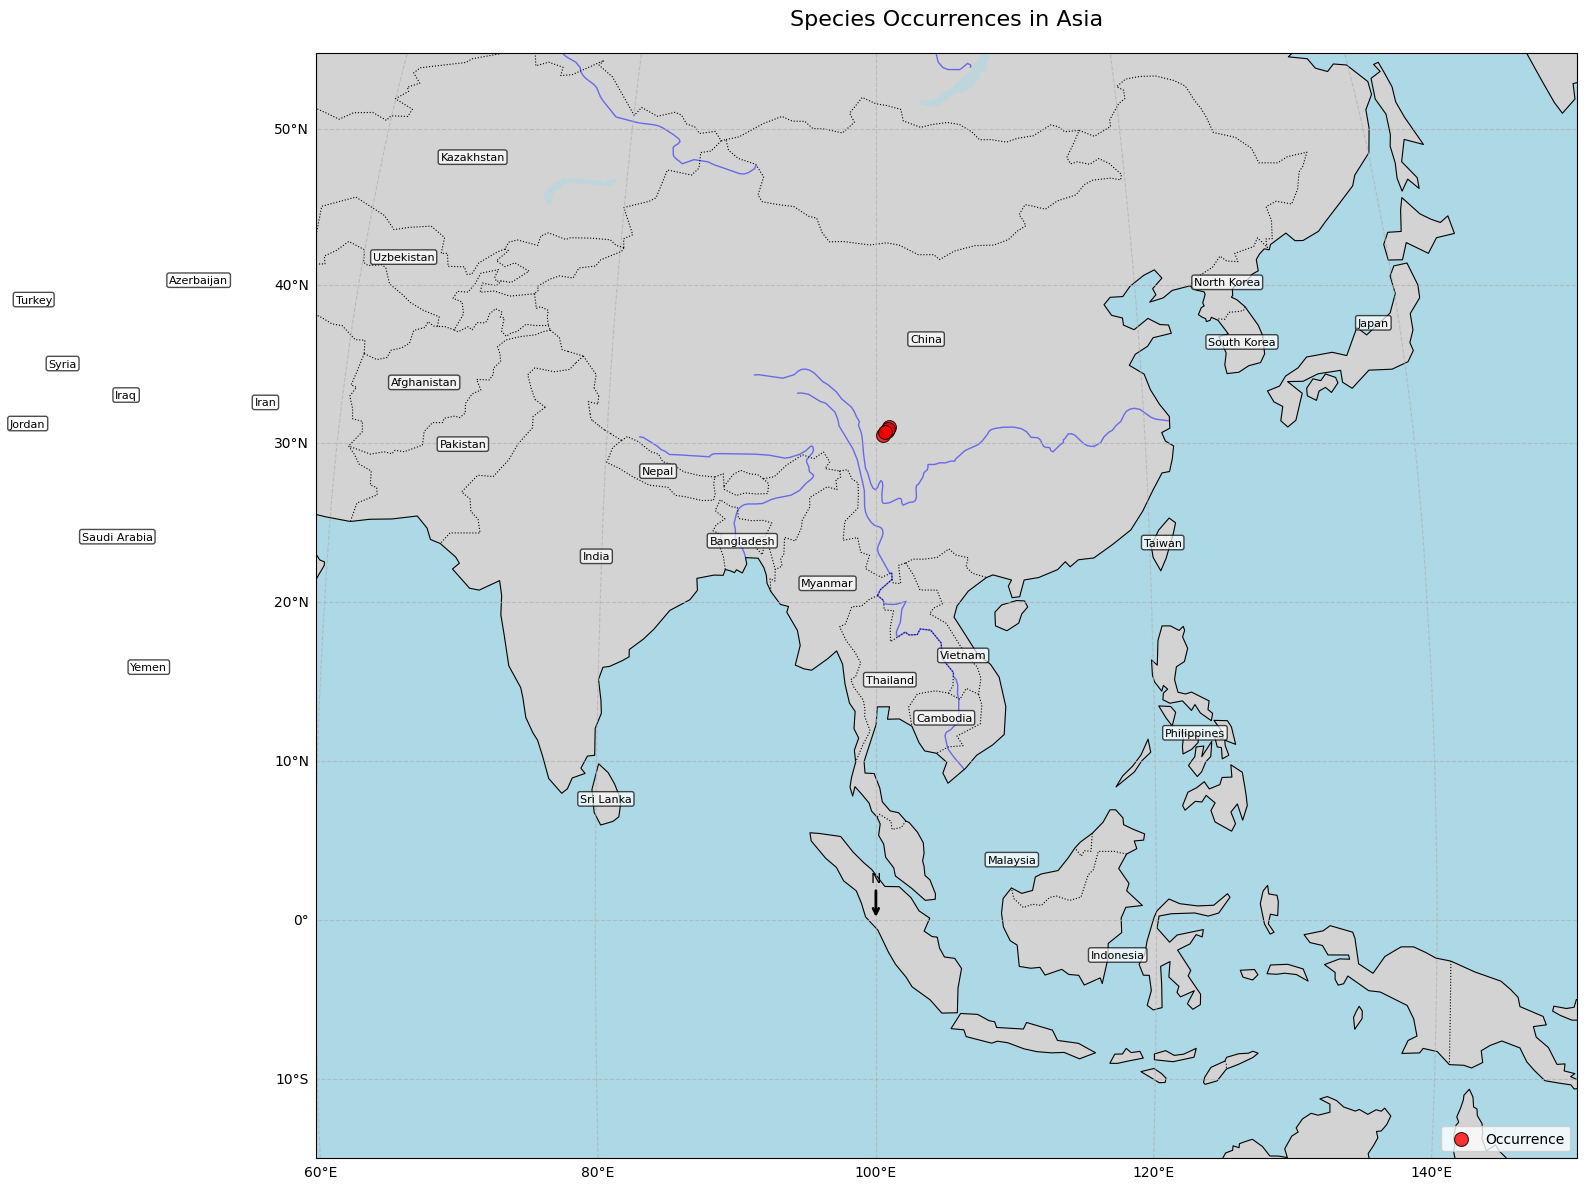

In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Create figure with a larger size
plt.figure(figsize=(16, 12))

# Create a map with a specific projection (Robinson works well for Asia)
ax = plt.axes(projection=ccrs.Robinson(central_longitude=100))

# Set the extent to focus on Asia
# [West, East, South, North]
ax.set_extent([60, 150, -15, 55], crs=ccrs.PlateCarree())

# Add high-resolution geographic features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.8)
ax.add_feature(cfeature.LAKES, alpha=0.5, facecolor='lightblue')
ax.add_feature(cfeature.RIVERS, edgecolor='blue', alpha=0.5)

# Add country names for better orientation
import cartopy.io.shapereader as shpreader
shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='50m',
                                      category='cultural', name=shapename)

# Add country labels
for country in shpreader.Reader(countries_shp).records():
    # Only label larger countries to avoid clutter
    if country.attributes['CONTINENT'] == 'Asia' and country.attributes['POP_EST'] > 10000000:
        x = country.geometry.centroid.x
        y = country.geometry.centroid.y
        plt.text(x, y, country.attributes['NAME'], 
                transform=ccrs.PlateCarree(),
                fontsize=8, ha='center', va='center',
                bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))

# Plot your data points
plt.scatter(
    df['longitude'],
    df['latitude'],
    color='red',
    s=100,
    transform=ccrs.PlateCarree(),
    label='Occurrence',
    edgecolor='black',
    linewidth=0.8,
    alpha=0.8,
    zorder=10
)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.7)
gl.top_labels = False
gl.right_labels = False

# Add title
plt.title('Species Occurrences in Asia', fontsize=16, pad=20)

# Add scale bar
def scale_bar(ax, length_km, location=(0.1, 0.1), linewidth=3):
    """Add a scale bar to the map"""
    # Length of the scale bar in degrees
    length_deg = length_km / 111  # Approximate conversion
    # Get the extent of the map
    x0, x1, y0, y1 = ax.get_extent()
    # Position of the scale bar
    x = x0 + (x1 - x0) * location[0]
    y = y0 + (y1 - y0) * location[1]
    # Add the scale bar
    ax.plot([x, x + length_deg], [y, y], 
            color='black', linewidth=linewidth, 
            transform=ccrs.PlateCarree())
    # Add the label
    ax.text(x + length_deg/2, y + (y1-y0)*0.01, 
           f'{length_km} km',
           ha='center', va='bottom',
           transform=ccrs.PlateCarree())

# Add scale bar (1000 km)
scale_bar(ax, 1000, location=(0.1, 0.1))

# Add north arrow
def add_north_arrow(ax, x=0.9, y=0.9, size=30):
    """Add a north arrow to the map"""
    ax.annotate('N', xy=(x, y), xytext=(0, size),
                textcoords='offset points', 
                ha='center', va='center',
                arrowprops=dict(arrowstyle='->', lw=2),
                transform=ax.transAxes)

add_north_arrow(ax)

# Add legend
plt.legend(loc='lower right')

# Adjust layout and show
plt.tight_layout()
plt.show()

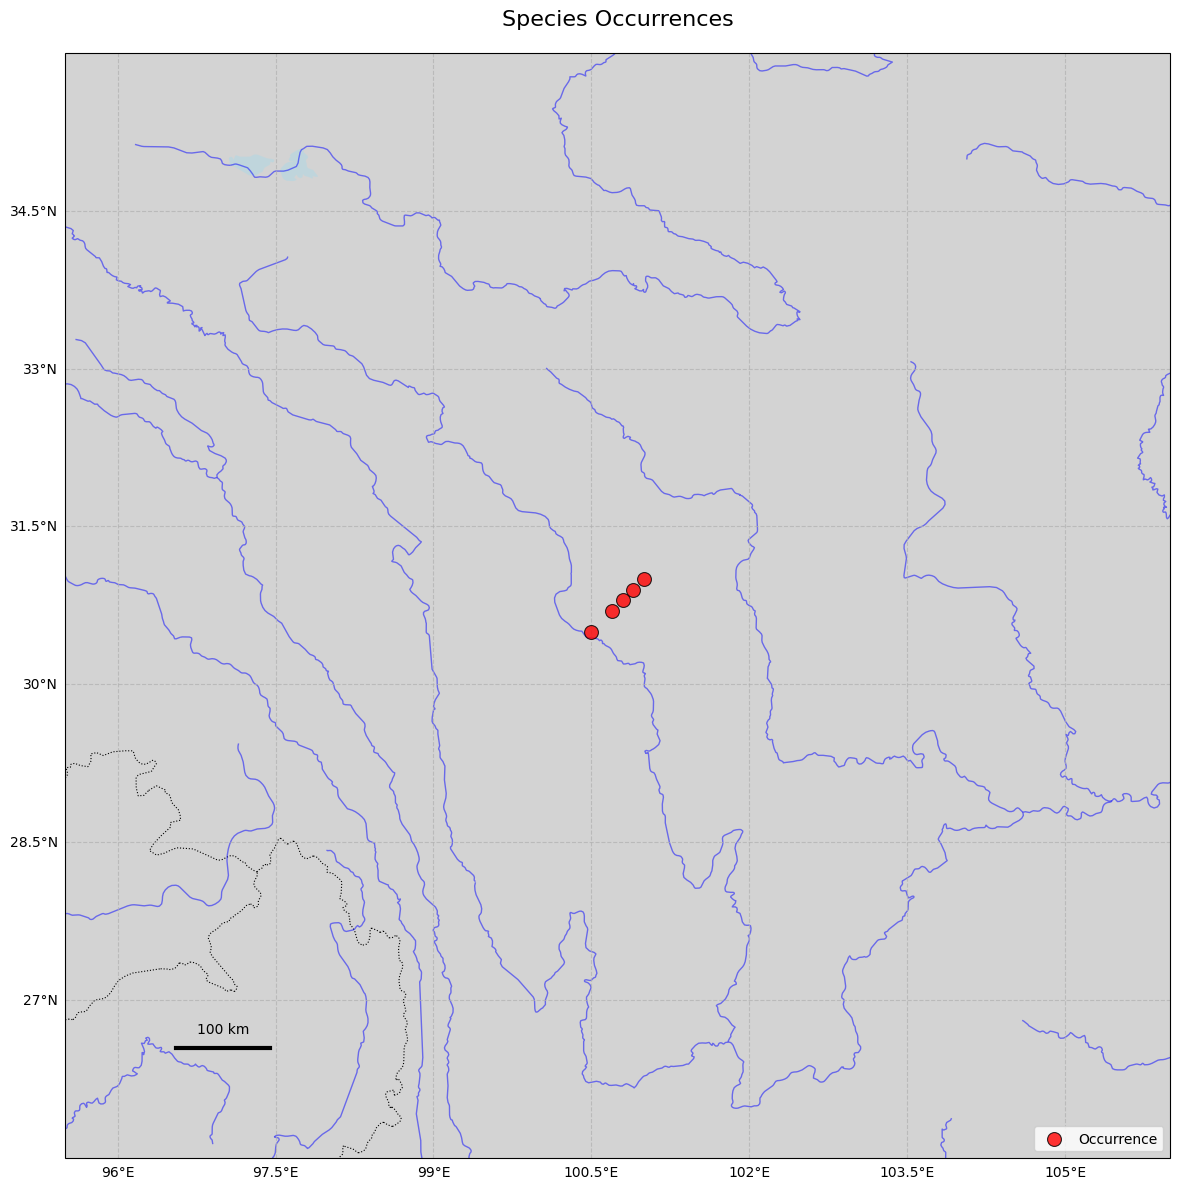

In [21]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.patches import FancyArrowPatch

# Calculate the bounding box with padding
padding = 5  # degrees of padding
lon_min, lon_max = df['longitude'].min() - padding, df['longitude'].max() + padding
lat_min, lat_max = df['latitude'].min() - padding, df['latitude'].max() + padding

# Create figure with a larger size
plt.figure(figsize=(16, 12))

# Create a map with a specific projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the extent to focus on the occurrence points with padding
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add high-resolution geographic features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.8)
ax.add_feature(cfeature.LAKES, alpha=0.5, facecolor='lightblue')
ax.add_feature(cfeature.RIVERS, edgecolor='blue', alpha=0.5)

# Add country names for better orientation
import cartopy.io.shapereader as shpreader
shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='50m',
                                      category='cultural', name=shapename)

# Add country labels
for country in shpreader.Reader(countries_shp).records():
    # Only label countries within the map extent
    if (country.attributes['CONTINENT'] == 'Asia' and 
        country.attributes['POP_EST'] > 5000000 and
        (lon_min <= country.geometry.centroid.x <= lon_max) and
        (lat_min <= country.geometry.centroid.y <= lat_max)):
        x = country.geometry.centroid.x
        y = country.geometry.centroid.y
        plt.text(x, y, country.attributes['NAME'], 
                transform=ccrs.PlateCarree(),
                fontsize=8, ha='center', va='center',
                bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))

# Plot your data points
plt.scatter(
    df['longitude'],
    df['latitude'],
    color='red',
    s=100,
    transform=ccrs.PlateCarree(),
    label='Occurrence',
    edgecolor='black',
    linewidth=0.8,
    alpha=0.8,
    zorder=10
)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.7)
gl.top_labels = False
gl.right_labels = False

# Add title
plt.title('Species Occurrences', fontsize=16, pad=20)

# Add scale bar
def scale_bar(ax, length_km, location=(0.1, 0.1), linewidth=3):
    """Add a scale bar to the map"""
    # Calculate the length in degrees (approximate)
    length_deg = length_km / 111  # 1 degree ≈ 111 km at the equator
    # Get the extent of the map
    x0, x1, y0, y1 = ax.get_extent()
    # Position of the scale bar
    x = x0 + (x1 - x0) * location[0]
    y = y0 + (y1 - y0) * location[1]
    # Add the scale bar
    ax.plot([x, x + length_deg], [y, y], 
            color='black', linewidth=linewidth, 
            transform=ccrs.PlateCarree())
    # Add the label
    ax.text(x + length_deg/2, y + (y1-y0)*0.01, 
           f'{length_km} km',
           ha='center', va='bottom',
           transform=ccrs.PlateCarree())

# Add scale bar (100 km)
scale_bar(ax, 100, location=(0.1, 0.1))

# Add north arrow
def add_north_arrow(ax, x=0.9, y=0.9, size=30):
    """Add a north arrow to the map"""
    ax.annotate('N', xy=(x, y), xytext=(0, size),
                textcoords='offset points', 
                ha='center', va='center',
                arrowprops=dict(arrowstyle='->', lw=2, color='black'),
                transform=ax.transAxes,
                color='black',
                fontsize=12,
                bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))

add_north_arrow(ax)

# Add legend
plt.legend(loc='lower right')

# Adjust layout and show
plt.tight_layout()
plt.show()

# Species Distribution Modeling (SDM) Analysis



## Methodology

### 1. Data Preparation
- **Occurrence Data**: Species presence points were obtained from GBIF (Global Biodiversity Information Facility).
- **Environmental Variables**: 19 bioclimatic variables (bio1-bio19) from WorldClim were used as predictors.
- **Background Points**: 1000 pseudo-absence points were randomly generated within the study area.

### 2. Model Architecture
- **Algorithm**: Random Forest Classifier
- **Parameters**:
  - Number of trees: 100
  - Random state: 42 (for reproducibility)
  - Test size: 30% (for validation)

### 3. Model Evaluation
The model's performance was evaluated using:
- **AUC-ROC Score**: Measures the model's ability to distinguish between presence and absence.
- **Accuracy**: The proportion of correctly classified instances.

## Results

### 1. Model Performance
- **AUC-ROC**: [Insert your AUC score here]
- **Accuracy**: [Insert your accuracy score here]

### 2. Feature Importance
The importance of each environmental variable in predicting species distribution

### 3. Predicted Distribution
The predicted habitat suitability map shows areas with high probability of species occurrence

## Interpretation

### Environmental Variables
1. **Most Important Variables**:
   - [Top variable 1]: [Brief explanation of its ecological significance]
   - [Top variable 2]: [Brief explanation of its ecological significance]

2. **Distribution Patterns**:
   - [Describe the main patterns in the predicted distribution]
   - [Note any unexpected findings or limitations]

## Limitations
The model assumes that the current distribution is in equilibrium with the environment.
Does not account for biotic interactions or dispersal limitations.
Resolution is limited by the input environmental data.
